In [29]:
import sys
import os 
sys.path.append(os.path.dirname(os.getcwd()))
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
from metrics import bootstrap_mrr_at_k, mrr_at_k, hit_rate_at_k, mrr_at_k_per_experiment, hit_rate_at_k_per_experiment
from models import get_model, get_pooled_dataset
from settings import DATA_FOLDER
from notebooks.experiment_data import get_experiment_data, split_experiment_train_test_val_data, FEATURES
from catboost import CatBoostRanker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
data = get_experiment_data()

users_df size before removing small experiments: 501008 rows
users_df size after removing small experiments: 500953 rows


In [31]:
feature_set = FEATURES.get_subset("creative_10")
train_data, _, test_data = split_experiment_train_test_val_data(data, n_last_test=4, n_last_val=0)
train_df, train_pool, train_group_ids, X_train, y_train = get_pooled_dataset(train_data, cols=feature_set.all, cat_cols=feature_set.categorical, pos_neg_ratio=1)
test_df, test_pool, test_group_ids, X_test, y_test = get_pooled_dataset(test_data, cols=feature_set.all, cat_cols=feature_set.categorical)

### Analyzing Feature Importance of the Trained Candidate Model


In [32]:
# Load trained catboost model
ranker = CatBoostRanker()
ranker.load_model("./cpu_ranking_candidate_model.cbm")


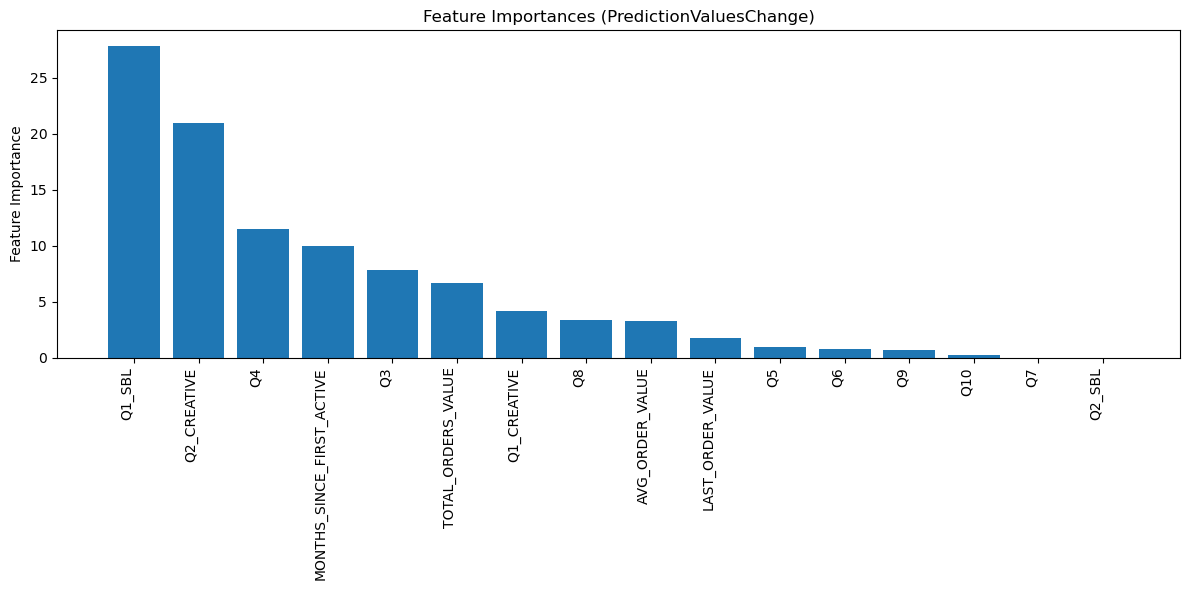

In [ ]:
# Get feature importance using PredictionValuesChange method
# This method works better for ranking models and returns one value per feature
importances = ranker.get_feature_importance(type='PredictionValuesChange')

# Create a DataFrame with feature names and their importances
feat_importances = pd.DataFrame({
    'feature': ranker.feature_names_,
    'importance': importances
})

# Sort by importance descending
feat_importances = feat_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feat_importances['feature'], feat_importances['importance'])
plt.xticks(rotation=90, ha='right')
plt.ylabel('Feature Importance')
plt.title('Feature Importances (PredictionValuesChange)')
plt.tight_layout()
plt.show()



### Analysis of Results for the Last 4 Experiments


In [34]:
scores = ranker.predict(test_pool)
preds = test_df.assign(
    PRED=scores
)[["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "PRED"]]
y_true = test_df[
    ["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID", "CLICK"]
].query("CLICK==1")

result =  pd.merge(preds, y_true, on=["EXPERIMENT_ID", "RECIPIENT_ID", "VARIATION_ID"], how="left").fillna(0)

In [35]:
last_4_experiments = [
    "823158da-7b0a-4c19-8189-663c22a3ae38",
    "cd4a656f-290a-41e2-be1d-bf62ad85757d",
    "78a802ae-d6cd-4f39-aecb-138668fa2607",
    "0ef6d2e9-7601-4df6-a215-83e6e79aa24e",
]
for i, experiment_id in enumerate(last_4_experiments, start=0):
    print(f"Experiment {4-i}: {experiment_id}")
    preds_experiment = preds.query(f"EXPERIMENT_ID == '{experiment_id}'")
    y_true_experiment = y_true.query(f"EXPERIMENT_ID == '{experiment_id}'")
    print(f"    Hit Rate@1 for experiment {4-i}: {hit_rate_at_k(preds_experiment, y_true_experiment, 1)}")
    print(f"    MRR@5 for experiment {4-i}: {mrr_at_k(preds_experiment, y_true_experiment, 5)}")

Experiment 4: 823158da-7b0a-4c19-8189-663c22a3ae38
    Hit Rate@1 for experiment 4: 0.16185476815398075
    MRR@5 for experiment 4: 0.44850539515893845
Experiment 3: cd4a656f-290a-41e2-be1d-bf62ad85757d
    Hit Rate@1 for experiment 3: 0.23833485818847208
    MRR@5 for experiment 3: 0.48002439768222027
Experiment 2: 78a802ae-d6cd-4f39-aecb-138668fa2607
    Hit Rate@1 for experiment 2: 0.3775241439859526
    MRR@5 for experiment 2: 0.6167690956979807
Experiment 1: 0ef6d2e9-7601-4df6-a215-83e6e79aa24e
    Hit Rate@1 for experiment 1: 0.33874709976798145
    MRR@5 for experiment 1: 0.5674787316318639


In [22]:
third_experiment = "cd4a656f-290a-41e2-be1d-bf62ad85757d"
result.query(f"EXPERIMENT_ID == '{third_experiment}'")[30:40]

,EXPERIMENT_ID,RECIPIENT_ID,VARIATION_ID,PRED,CLICK
21188,cd4a656f-290a-41e2-be1d-bf62ad85757d,01EZD74P95G8G8N5KRAN521Q0S,8ecbf689-6bed-4b33-b860-f811a2cd49cb,1.849803,1.0
21189,cd4a656f-290a-41e2-be1d-bf62ad85757d,01EZD74P95G8G8N5KRAN521Q0S,ebd41fbe-8cf1-4bc9-99e7-421a7a31bfc3,1.854351,0.0
21190,cd4a656f-290a-41e2-be1d-bf62ad85757d,01EZD74P95G8G8N5KRAN521Q0S,871907d7-ceec-4b29-bfee-12911d920b75,1.854351,0.0
21191,cd4a656f-290a-41e2-be1d-bf62ad85757d,01EZD74P95G8G8N5KRAN521Q0S,32a09741-d4de-4541-9b99-6f1c3792e149,1.840937,0.0
21192,cd4a656f-290a-41e2-be1d-bf62ad85757d,01EZD74P95G8G8N5KRAN521Q0S,352d9e77-a7f0-474a-9edf-c4392f610ec3,1.849803,0.0
21193,cd4a656f-290a-41e2-be1d-bf62ad85757d,01F0KXY5A3S3CM57ZH206SRS78,8ecbf689-6bed-4b33-b860-f811a2cd49cb,-1.878668,0.0
21194,cd4a656f-290a-41e2-be1d-bf62ad85757d,01F0KXY5A3S3CM57ZH206SRS78,ebd41fbe-8cf1-4bc9-99e7-421a7a31bfc3,-1.874120,0.0
21195,cd4a656f-290a-41e2-be1d-bf62ad85757d,01F0KXY5A3S3CM57ZH206SRS78,871907d7-ceec-4b29-bfee-12911d920b75,-1.874120,0.0
21196,cd4a656f-290a-41e2-be1d-bf62ad85757d,01F0KXY5A3S3CM57ZH206SRS78,32a09741-d4de-4541-9b99-6f1c3792e149,-1.887535,0.0
21197,cd4a656f-290a-41e2-be1d-bf62ad85757d,01F0KXY5A3S3CM57ZH206SRS78,352d9e77-a7f0-474a-9edf-c4392f610ec3,-1.878668,1.0


In [ ]:
clicks_df = pd.read_csv(DATA_FOLDER / "processed/clicked_variation_rows_v2.csv")

,EXPERIMENT_ID,VARIATION_ID,MONTH,DAY,HOUR,LAST_CLICKED_VARIATION_ID,RECIPIENT_ID,CITY,COUNTRY,REGION,...,LATEST_CLICK_CLIENT_TYPE,LATEST_CLICK_CLIENT_OS_FAMILY,LATEST_CLICK_CLIENT_NAME,TOTAL_CLICK_COUNT,AVG_CLICK_HOUR_OF_DAY,FIRST_ACTIVE_TS,FIRST_UTM_SOURCE,FIRST_UTM_CONTENT,FIRST_UTM_CAMPAIGN,CLICK_COUNT
0,43d750b5-8698-4cf0-9ea2-f705f4f196ed,869cd96a-2cf5-46e7-9c65-db5088bb335a,9,25,14,NaN,01K4PW28GASR4GPQ9KXH0K8FRE,Richardson,United States,Texas,...,Browser,OS X,Safari,4,11.03,2025-09-13 15:02:59.000,NaN,NaN,NaN,1
1,81ae4870-e57d-4bc4-a2d7-48ffa5411707,99e778d6-f7a3-404f-8abb-9f9027be9598,7,10,12,NaN,01HA2FPZHDHQ7E6RVB42YQ8T00,Westfield,United States,New Jersey,...,Mobile Browser,iOS,Mobile Safari,7,17.20,2025-04-13 23:27:58.000,NaN,NaN,NaN,1
2,43d750b5-8698-4cf0-9ea2-f705f4f196ed,a472cd3a-d719-4a99-bb89-7ba8a2e0e84c,9,25,12,99e778d6-f7a3-404f-8abb-9f9027be9598,01HA2FPZHDHQ7E6RVB42YQ8T00,Westfield,United States,New Jersey,...,Mobile Browser,iOS,Mobile Safari,7,17.20,2025-04-13 23:27:58.000,NaN,NaN,NaN,1
3,e627d7f0-46c4-4894-872e-59a2fc108c30,0fbe8e48-16a7-46bf-88eb-0347190a7e6d,8,7,12,NaN,01G32GY39RH4RYKBFG9B89Z7MY,republic,United States,Ohio,...,Mobile Browser,iOS,Mobile Safari,33,16.94,2025-01-01 00:50:33.000,NaN,NaN,NaN,4
4,49c33d7c-ef04-43a7-bbd0-783489c64849,2dd79b7f-a399-459e-8eb0-6baf3a22f53b,9,6,12,NaN,01J7GBJ3QQ0H62CMSJWTSCVJNE,Shakopee,United States,Minnesota,...,Mobile Browser,iOS,Mobile Safari,6,15.52,2025-03-05 15:25:20.000,Klaviyo,NaN,em - new just dropped 445 lace bra white - Wed...,1


In [34]:
print(clicks_df.columns)

Index(['EXPERIMENT_ID', 'VARIATION_ID', 'MONTH', 'DAY', 'HOUR',
       'LAST_CLICKED_VARIATION_ID', 'RECIPIENT_ID', 'CITY', 'COUNTRY',
       'REGION', 'TIMEZONE', 'LAST_EVENT_DATE', 'LAST_ORDER_VALUE',
       'TOTAL_ORDERS_VALUE', 'AVG_ORDER_VALUE', 'ORDER_COUNT',
       'LATEST_CLICK_DATE', 'LATEST_CLICK_CLIENT_TYPE',
       'LATEST_CLICK_CLIENT_OS_FAMILY', 'LATEST_CLICK_CLIENT_NAME',
       'TOTAL_CLICK_COUNT', 'AVG_CLICK_HOUR_OF_DAY', 'FIRST_ACTIVE_TS',
       'FIRST_UTM_SOURCE', 'FIRST_UTM_CONTENT', 'FIRST_UTM_CAMPAIGN',
       'CLICK_COUNT'],
      dtype='object')


In [33]:
clicks_df[~clicks_df["LAST_CLICKED_VARIATION_ID"].isna()]

,EXPERIMENT_ID,VARIATION_ID,MONTH,DAY,HOUR,LAST_CLICKED_VARIATION_ID,RECIPIENT_ID,CITY,COUNTRY,REGION,...,LATEST_CLICK_CLIENT_TYPE,LATEST_CLICK_CLIENT_OS_FAMILY,LATEST_CLICK_CLIENT_NAME,TOTAL_CLICK_COUNT,AVG_CLICK_HOUR_OF_DAY,FIRST_ACTIVE_TS,FIRST_UTM_SOURCE,FIRST_UTM_CONTENT,FIRST_UTM_CAMPAIGN,CLICK_COUNT
2,43d750b5-8698-4cf0-9ea2-f705f4f196ed,a472cd3a-d719-4a99-bb89-7ba8a2e0e84c,9,25,12,99e778d6-f7a3-404f-8abb-9f9027be9598,01HA2FPZHDHQ7E6RVB42YQ8T00,Westfield,United States,New Jersey,...,Mobile Browser,iOS,Mobile Safari,7,17.20,2025-04-13 23:27:58.000,NaN,NaN,NaN,1
7,823158da-7b0a-4c19-8189-663c22a3ae38,c1829730-c2e1-4327-9c3e-9b1780ff59f4,9,27,15,2d28bc00-b26c-461a-b25b-802c9c3dad96,01K0HB1J4MXZP36AQ7GN2ABDVF,Concord,United States,North Carolina,...,Mobile Browser,iOS,Mobile Safari,5,18.85,2025-07-19 12:37:29.000,google,The Comfort Shaping Bra,703464215258,1
9,9cd54b2b-31f9-43e4-9073-0d2b61bf9f15,0b5f5927-0b45-414c-b5c7-1b34ba85510e,8,30,18,63fd891e-efb2-4c09-b74e-f3aa9205aa37,01GEWHVK6EBS4CMN7VFYSRV2DG,MOUNTAIN HOME,United States,Arkansas,...,Browser,Windows,Chrome,19,17.89,2025-02-23 18:03:11.000,Klaviyo,NaN,em - Just Dropped Italian Plum 670 T-shirt - S...,1
12,002deaf7-331f-4b5e-866b-f6dad60e4a79,e21d7ef6-3bda-41fc-a67d-3f7fed61befc,7,28,12,78dd7ab2-320f-493b-a7f9-8ea940cf570d,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,United States,NaN,...,Mobile Browser,iOS,Mobile Safari,7,9.78,2025-05-25 01:42:25.000,NaN,NaN,NaN,1
13,a1db5d4b-b641-4d3d-a8a6-d4c9bdd9c033,a8efba07-c4d3-4d0d-8a38-6f7e32c53371,8,23,18,e21d7ef6-3bda-41fc-a67d-3f7fed61befc,01HQ0YTRRARPWHJ3NN24ME1NH0,NaN,United States,NaN,...,Mobile Browser,iOS,Mobile Safari,7,9.78,2025-05-25 01:42:25.000,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47685,9defe9fd-0374-4de6-99f7-aaa392903d67,2b87840b-b616-41d7-b456-f22a7099a78a,8,12,12,15be91b7-6b55-4cd3-8d07-f4068b018a3a,01JYMTVPPS4T4T59NQ9TTKWHC3,Huntington,United States,Indiana,...,Mobile Browser,Android,Chrome Mobile,4,13.51,2025-06-09 01:28:17.000,fb,120218997160760318,457 Add-to-cart,1
47690,1d6dbba7-dcc5-46f4-a4aa-aef3124a8fcf,cffea4bb-b081-4d10-b0d3-1ab57578e473,9,5,12,2968d945-ec27-4bbb-8a6b-4a92db7266de,01J56XZTSXSFH1877521N0Y4DH,Franklin,United States,Tennessee,...,Mobile Browser,iOS,Mobile Safari,42,13.99,2025-01-06 17:22:33.000,NaN,NaN,NaN,1
47694,e697ab50-0abb-42d3-92a0-43f1ed597476,71995c0d-3a29-4098-aec0-505734948e83,8,29,12,e90ad906-b6f0-4e29-965b-1e5ef3ef6116,01HX7M6T0MDXMR604Z19Z62Z1N,Washington,US,MO,...,Mobile Browser,iOS,Mobile Safari,16,15.56,2025-01-04 20:29:31.000,NaN,NaN,NaN,1
47706,e4b4a349-3b14-439e-946f-f716101dac69,e90782b8-e1b7-4b48-9b34-b2bc8986d7df,8,2,12,eefc2d0d-daee-4e5e-b924-9108f6f8841d,01HCQ5MS4HVPFT9SN01TH5C0J9,PORT ORANGE,United States,Florida,...,Browser,OS X,Chrome,13,19.04,2025-01-10 11:00:52.000,Klaviyo,NaN,em - Winter sale - Thu Jan 9 2025 9am - your s...,1


In [ ]:
clicks_df[["EXPERIMENT_ID", "RECIPIENT_ID"]]

,EXPERIMENT_ID,RECIPIENT_ID
0,43d750b5-8698-4cf0-9ea2-f705f4f196ed,01K4PW28GASR4GPQ9KXH0K8FRE
1,81ae4870-e57d-4bc4-a2d7-48ffa5411707,01HA2FPZHDHQ7E6RVB42YQ8T00
2,43d750b5-8698-4cf0-9ea2-f705f4f196ed,01HA2FPZHDHQ7E6RVB42YQ8T00
3,e627d7f0-46c4-4894-872e-59a2fc108c30,01G32GY39RH4RYKBFG9B89Z7MY
4,49c33d7c-ef04-43a7-bbd0-783489c64849,01J7GBJ3QQ0H62CMSJWTSCVJNE
...,...,...
47705,3ecf34fc-1f15-4b32-970f-4061544da763,01HCQ5MS4HVPFT9SN01TH5C0J9
47706,e4b4a349-3b14-439e-946f-f716101dac69,01HCQ5MS4HVPFT9SN01TH5C0J9
47707,1d6dbba7-dcc5-46f4-a4aa-aef3124a8fcf,01J0NPQ7RFF8FYPWPWNY9WT6J3
47708,49c33d7c-ef04-43a7-bbd0-783489c64849,01J0NPQ7RFF8FYPWPWNY9WT6J3
